In [29]:
import numpy as np
import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
%config InlineBackend.figure_formats = ['svg']
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm as progress
import torch
from numpy.linalg import norm 
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
import torch.optim as optim
from torch import nn
from keras.datasets import fashion_mnist
import torch.nn.functional as F
import time
from time import sleep
from tqdm import tqdm
def expspace(a,b,n):
    return np.exp(np.linspace(np.log(a),np.log(b),n))

def expspace_int(a,b,n):
    return np.unique(np.round(expspace(a,b,n)).astype(int))

In [30]:
(train_x, train_y), (test_x, test_y) = fashion_mnist.load_data()

In [31]:
#the fashion mnist data is organized in the right shape (cat stands for category)
# first: the tensors are flattened
train_x_flat=train_x.reshape(train_x.shape[0],-1)
test_x_flat=test_x.reshape(test_x.shape[0],-1)

#second: the training dataset is configured as:
#- num_train, the tensor containing the pixel of the images
#- cat_train, the tensor containing the true labels in a one-hot encoded fashion: 
#- cat_tr, the tensor containing the original labels i.e. in {0->9}
num_train=torch.tensor(train_x_flat,dtype=torch.float64)
cat_train=F.one_hot(torch.tensor(train_y,dtype=torch.int64),num_classes=10)
cat_tr=torch.tensor(train_y,dtype=torch.int64)

# the same happens for the testset.
num_test=torch.tensor(test_x_flat,dtype=torch.float64)
cat_test=F.one_hot(torch.tensor(test_y,dtype=torch.int64),num_classes=10)
cat_te=torch.tensor(test_y,dtype=torch.int64)


In [27]:
def param(K,num_train,d,model):#parameters initialization
    N=num_train.shape[1]
    tot=K*N+K+10*K+10
    if model =="sparse":
        P=sparse(tot,d)
    if model =="sparse_deep":
        P=sparse_deep(tot,d)
    if model =="dense":
        P=dense(tot,d)
    θ_0=torch.randn(tot,dtype=torch.float64)/(torch.tensor(N))
    θ_d=torch.randn(d,requires_grad=True,dtype=torch.float64)/(torch.tensor(N))
    return P,θ_0,θ_d.clone().detach().requires_grad_(True) #torch.tensor(θ_d,requires_grad=True)

def param_std(K,num_train):
    #parameters initialization for standard network (without training on parameters subspaces)
    N=num_train.shape[1]
    tot=K*N+K+10*K+10
    W=torch.randn(tot,dtype=torch.float64)/(torch.tensor(N))
    return W.clone().detach().requires_grad_(True)


def sparse(D,d):
    #generating the sparse projection matrix 
    row=torch.randint(0,D,(d*round(np.sqrt(D)),))
    column=torch.randint(0,d,(d*round(np.sqrt(D)),))
    indexes=torch.stack((row,column),dim=0)
    values=torch.sign(1-2*torch.rand((indexes.shape[1],),dtype=torch.float64))*np.sqrt(1/np.sqrt(D))
    smat=torch.sparse_coo_tensor(indexes,values,(D,d))
    return smat

def sparse_deep(D,d):
    #generating the deeply sparse projection matrix 
    row=torch.randint(0,D,(round(np.sqrt(d*D)),))
    column=torch.randint(0,d,(round(np.sqrt(d*D)),))
    indexes=torch.stack((row,column),dim=0)
    values=torch.sign(1-2*torch.rand((indexes.shape[1],),dtype=torch.float64))*np.sqrt(np.sqrt(d)/np.sqrt(D))
    smat=torch.sparse_coo_tensor(indexes,values,(D,d))
    return smat

def dense(D,d):
    #generating the dense projection matrix
    P=torch.randn((D,d),dtype=torch.float64)
    n=torch.norm(P,dim=0)
    return P/n

def batch(num_train,cat_train):
    #constructing a random mini-batch from the pixel-tensor and the category-tensor
    batch_dim=1250
    n = np.random.randint(num_train.shape[0],size=batch_dim)
    return num_train[n,:],cat_train[n]


def loss(soft,cat_train):
    #loss function, which takes as input the result of the softmax (soft) and the true labels (cat)
    eps = 1e-8
    lo=-torch.sum(cat_train*torch.log(soft+eps))
    return lo

def l(num_train,W,K):
    #num_train: input
    #W: tensor of parameters for the NN
    #K: dimension of the hidden layer
    #** the vector of the parameters W is unpacked into weights (M1,M2) and biases (b1,b2)
    N=num_train.shape[1]
    M1=W[0:(N*K)].reshape(N,K)
    b1=W[(N*K):(N*K+K)]
    M2 = W[(N*K+K):(N*K+11*K)].reshape(K,10)
    b2=W[-11:-1]
    m = nn.LeakyReLU(0.1)
    z=m(num_train@M1+b1)
    return nn.Softmax(dim=1)(z@M2+b2) #this function returns the probabilities assigned by the NN 

def train(cat_train,num_train,d,K,model):
    #training function
    P,θ_0,θ_d=param(K,num_train,d,model)   #parameters initialization
    N = num_train.shape[1]
    optimizer = optim.Adam([θ_d],lr=0.001)
    for i in range(1500):
        optimizer.zero_grad()
        W=θ_0+P@θ_d                        #computing the W matrix
        im,ca=batch(num_train,cat_train)
        pred=l(im,W,K)                     #network prediction to be used as input of the loss
        los=loss(pred,ca)
        los.backward()
        optimizer.step()
    return W,loss(pred,ca)

def train_std(cat_train,num_train,K):
    #training function for the standard network (without training on parameters subspaces)
    W=param_std(K,num_train)
    N = num_train.shape[1]
    optimizer = optim.Adam([W],lr=0.001)
    for i in range(1500):
        optimizer.zero_grad()
        im,ca=batch(num_train,cat_train)
        pred=l(im,W,K)                    #network prediction to be used as input of the loss
        los=loss(pred,ca)
        los.backward()
        optimizer.step()
    return W,loss(pred,ca)


def performance(W,num_test,cat_te,K):
    #performance of the network
    pred=l(num_test,W,K)
    return torch.mean((torch.argmax(pred,dim=1) == cat_te)*1.0)*100

In [34]:
#function to evaluate the computational time and accuracy for different realization of the projection matrix P
def computational_time(model_type,vd,K):
    t=np.zeros(len(vd))
    perf=np.zeros(len(vd))
    for i,d in enumerate(tqdm(vd)):
        temp=np.zeros(5)
        for j in range(0,5):
            start = time.time()
            W,lW=train(cat_train,num_train,d,K,model_type)
            end = time.time()
            temp[j]=(end-start)*1.0
        t[i]=min(temp)
        perf[i]=performance(W,num_test,cat_te,K)
    return t,perf 

In [36]:
K=10
vd=expspace_int(10,1000,10)
t,perfd=computational_time("dense",vd,K)
ts,perfspa=computational_time("sparse",vd,K)
tss,perfspadeep=computational_time("sparse_deep",vd,K)

100%|███████████████████████████████████████████| 10/10 [12:24<00:00, 74.47s/it]


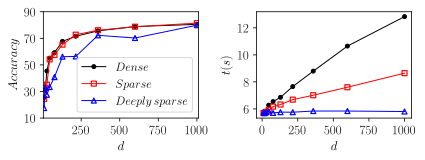

In [37]:
plt.figure(figsize=(6, 2.3333))
plt.subplot(1, 2, 1)
plt.plot(vd,perfd,"-o",color="black",markersize=4,lw=1,label=r"$Dense$")
plt.plot(vd,perfspa,"-s",markerfacecolor="none",color="red",markersize=5,markeredgewidth=1.2,lw=1, label=r"$Sparse$")
plt.plot(vd,perfspadeep,"-^",markerfacecolor="none",color="blue",markersize=5,markeredgewidth=1.2,lw=1, label=r"$Deeply\,sparse$")
plt.legend(loc="lower right",fontsize=12)
plt.ylabel(r"$Accuracy$",fontsize=13)
plt.xlabel(r"$d$",fontsize=13)
plt.ylim(10,90)
plt.yticks(np.linspace(10,90,5),fontsize=13)
plt.xticks(fontsize=13)
plt.xlim(5,1010)
#plt.annotate(r"$a)$", (-233.0, 80.0), fontsize="x-large", annotation_clip=False)
plt.tight_layout()
plt.subplot(1, 2, 2)
plt.plot(vd,t,"-o",color="black",markersize=4,lw=1,label=r"$Dense$")
plt.plot(vd,ts,"-s",markerfacecolor="none",color="red",markersize=5,markeredgewidth=1.2,lw=1, label=r"$Sparse$")
plt.plot(vd,tss,"-^",markerfacecolor="none",color="blue",markersize=5,markeredgewidth=1.2,lw=1, label=r"$Deeply\,sparse$")
plt.xlabel(r"$d$",fontsize=13)
plt.ylabel(r"$t(s)$",fontsize=13)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
#plt.annotate(r"$b)$", (-300.0, 12.0), fontsize="x-large", annotation_clip=False)
plt.tight_layout()
plt.savefig('dense_vs_sparse2.pdf')

In [38]:
#comparing a standard network with a bigger network (with an hidden layer twice as large as the other) trained on a  parameters space of the same dimension 
K=expspace_int(1,15,10)
lk=len(K)
N=num_train.shape[1]
d=K*N+K+10*K+10
perf_densa=torch.zeros((lk),dtype=torch.float64)
perf_standard=torch.zeros((lk),dtype=torch.float64)
loss_v=torch.zeros((lk),dtype=torch.float64)
loss_std=torch.zeros((lk),dtype=torch.float64)
for i in tqdm(range(lk)):
    #projected network
    W,lW=train(cat_train,num_train,d[i],2*K[i],"dense")
    loss_v[i]=lW*1.0
    perf_densa[i]=performance(W,num_test,cat_te,2*K[i])*1.0
    #standard network
    W_s,lW_s=train_std(cat_train,num_train,K[i])
    loss_std[i]=lW_s*1.0#
    perf_standard[i]=performance(W_s,num_test,cat_te,K[i])*1.0


100%|█████████████████████████████████████████████| 8/8 [07:11<00:00, 53.91s/it]


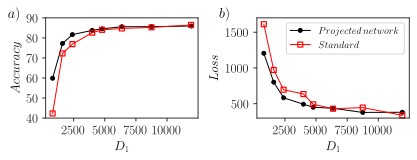

In [39]:
plt.figure(figsize=(6, 2.3333))
plt.subplot(1, 2, 1)
plt.annotate(r"$a)$", (-2800.0, 90.0), fontsize="x-large", annotation_clip=False)
plt.plot(d,perf_densa,"-o",color="black",markersize=4,lw=1)
plt.plot(d,perf_standard,"-s",markerfacecolor="none",color="red",markersize=5,markeredgewidth=1.2,lw=1)
plt.ylabel(r"$Accuracy$",fontsize=13)
plt.xlabel(r"$D_1$",fontsize=13)
plt.ylim(40,90)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()
plt.subplot(1, 2, 2)
plt.annotate(r"$b)$", (-2800.0, 1700.0), fontsize="x-large", annotation_clip=False)
plt.plot(d,loss_v.detach().numpy(),"-o",color="black",markersize=4,lw=1,label=r"$Projected\,network$")
plt.plot(d,loss_std.detach().numpy(),"-s",markerfacecolor="none",color="red",markersize=5,markeredgewidth=1.2,lw=1, label=r"$Standard$")
plt.ylabel(r"$Loss$",fontsize=13)
plt.xlabel(r"$D_1$",fontsize=13)
plt.legend(loc="upper right",fontsize=10)
plt.ylim(300,1700)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()
plt.savefig('dense_vs_standard.pdf')

In [40]:
#standard network performance 
D=expspace_int(100,28000,5)
perf_deeply=np.zeros((2,10))
K=10,100
for j,k in enumerate(K):
    for i,d in enumerate(D):
        W,lW=train(cat_train,num_train,d,k,"sparse_deep")
        pred_te=l(num_test,W,k)
        perf_deeply[j,i]=torch.mean((torch.argmax(pred_te,dim=1) == cat_te)*1.0)*100
        print(perf_deeply[j,i])

52.929996490478516
74.86000061035156
82.37000274658203
84.52999877929688
84.36000061035156
58.17000198364258
77.6500015258789
83.95999908447266
86.20999908447266
87.36000061035156
